# AI-PBPK model project: hyperparameters tuning with BayesSearchCV
Author: Kun Mi
Date created: 2025/05/07

Description: In this study, we used ML and Deep nerual network models to predict the require parameter which can be inputed into the PBPK model  


# Install and import required python pacakges

In [ ]:
# Install python pacakges
#!pip install pycaret==2.3.10 markupsafe==2.0.1 pyyaml==5.4.1 -qq
!pip install -q lightgbm # install the lightgbm package
!pip install -q scikit-optimize # install the package used for Bayesian optimization
!pip install -q scikeras[tensorflow]
!pip install -q keras-tuner
!pip install -q optuna

In [ ]:
#Install basic python pcakges
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_log_error
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from time import time

# Link to google drive and set up your project folder

In [ ]:
#Mount drive to google colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Set your working directory to a speicifc folder in your Google Drive
# The base Google Drive directory
root_dir = "/content/drive/My Drive/Colab Notebooks/2-AI-PBPK"

# choose where you want your project files to be saved
project_folder = "/Final model/" # Name your project here. Please instead the "my project folder" to your prefer name

# Make sure that floder exists. If not, automatically create a new folder
if (not os.path.isdir(root_dir + project_folder)):
  os.mkdir(root_dir + project_folder)
  print(root_dir + project_folder + 'did not exist but was created.')

# Change the OS to use your project folder as the working directory
os.chdir(root_dir + project_folder)

Mounted at /content/drive


# Data exploration

In [ ]:
# importer Data
Data = pd.read_csv(os.path.join(root_dir + project_folder + "Data-1.csv"))

# Data preprocessing I: missing Values  
Most Machine leanring algorithms canot work with missing features. So, we need to use `SimpleImputer` to replace missing values with median, mean or frequently used values.

In [ ]:
# see how many missing values in your dataset
Data.isna().sum()

,0
Ori,152
ID,0
Type,0
TS,0
MAT,0
Size,46
Zeta,71
Charge,66
Shape,0
TM,0


In [ ]:
# Remove the row with missing data
Data=Data.dropna(subset=['Size','Zeta','Charge']) # you can use 'subset' (e.g., dropna(subset='HD')) to remove the missing value in specific column

In [ ]:
df = pd.DataFrame(Data)

q_high=df["KTRESn"].quantile(0.975)
q_low=df["KTRESn"].quantile(0.025)
df_filtered=df[(df["KTRESn"]<q_high)&(df["KTRESn"]>q_low)]

df_X = df_filtered[["Type","TS",'MAT',"Size","Zeta","Shape","TSz","TM","CT",'Charge']]
df_y = df_filtered[["KTRESn"]]

In [ ]:
#Define the variable type
cols_num = ['Size','Zeta','TSz'] #Numerical value
cols_label = ["Type",'TS','Charge','Shape','TM','CT','MAT'] # Label value

# 3. One-hot Encoding



In [ ]:
test_X = df_X

In [ ]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(sparse_output=False)
cols_label_1hot = ["Type",'TS','Charge','Shape','TM','CT',"MAT"]
data_cat_1hot = pd.DataFrame(cat_encoder.fit_transform(test_X[cols_label_1hot]))
data_cat_1hot.columns = cat_encoder.get_feature_names_out(cols_label_1hot)

print(data_cat_1hot)

     Type_Hybrid  Type_Inorganic  Type_Organic  TS_Active  TS_Passive  \
0            0.0             1.0           0.0        1.0         0.0   
1            0.0             1.0           0.0        0.0         1.0   
2            0.0             1.0           0.0        1.0         0.0   
3            0.0             1.0           0.0        0.0         1.0   
4            0.0             1.0           0.0        1.0         0.0   
..           ...             ...           ...        ...         ...   
397          0.0             1.0           0.0        1.0         0.0   
398          0.0             0.0           1.0        1.0         0.0   
399          0.0             0.0           1.0        1.0         0.0   
400          1.0             0.0           0.0        1.0         0.0   
401          0.0             0.0           1.0        0.0         1.0   

     Charge_Negative  Charge_Neutral  Charge_Positive  Shape_Others  \
0                0.0             1.0              0.

# 4. Model normalization


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
cols_num = ['Size','Zeta','TSz']

mscaler = MinMaxScaler()
Data_num_tr = pd.DataFrame(mscaler.fit_transform(test_X[cols_num]))
Data_num_tr.columns = list(test_X[cols_num].columns)
print(Data_num_tr)

         Size      Zeta       TSz
0    0.086602  0.440698  0.176214
1    0.078449  0.440698  0.176214
2    0.144777  0.409178  0.036715
3    0.359850  0.433368  0.255823
4    0.381005  0.440698  0.255823
..        ...       ...       ...
397  0.147739  0.382788  0.014212
398  0.346188  0.396863  0.018950
399  0.350595  0.398475  0.018950
400  0.214412  0.375443  0.131465
401  0.038123  0.475150  0.018950

[402 rows x 3 columns]


# Compile data

In [ ]:
preData=pd.concat([Data_num_tr,data_cat_1hot], axis=1)
print(preData)

         Size      Zeta       TSz  Type_Hybrid  Type_Inorganic  Type_Organic  \
0    0.086602  0.440698  0.176214          0.0             1.0           0.0   
1    0.078449  0.440698  0.176214          0.0             1.0           0.0   
2    0.144777  0.409178  0.036715          0.0             1.0           0.0   
3    0.359850  0.433368  0.255823          0.0             1.0           0.0   
4    0.381005  0.440698  0.255823          0.0             1.0           0.0   
..        ...       ...       ...          ...             ...           ...   
397  0.147739  0.382788  0.014212          0.0             1.0           0.0   
398  0.346188  0.396863  0.018950          0.0             0.0           1.0   
399  0.350595  0.398475  0.018950          0.0             0.0           1.0   
400  0.214412  0.375443  0.131465          1.0             0.0           0.0   
401  0.038123  0.475150  0.018950          0.0             0.0           1.0   

     TS_Active  TS_Passive  Charge_Nega

# Define X and y

In [ ]:
y_re = df_y
X_re = preData

#Data split

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_re, y_re, test_size = 0.2, random_state=35)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(321, 42) (81, 42) (321, 1) (81, 1)


# LightGbm model with pretest

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.svm import SVC,SVR
import lightgbm as lgb

from sklearn.model_selection import KFold
from sklearn.metrics import r2_score,root_mean_squared_error
import warnings
warnings.filterwarnings("ignore")

from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.kernel_ridge import KernelRidge

### Evaluate function

In [ ]:
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

def evaluate_model(model, X_train, y_train, X_test, y_test, model_name="Model"):

    print(f"\n=== Evaluation for: {model_name} ===")

    # Define KFold for cross-validation
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # Cross-validation scores
    cv_r2 = cross_val_score(model, X_train, y_train, cv=cv, scoring="r2")
    cv_rmse = -cross_val_score(model, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error")

    # Fit model before test prediction
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    test_r2 = r2_score(y_test, y_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Output
    print("\nTest Set Performance:")
    print(f"R2 Score : {test_r2:.3f}")
    print(f"RMSE     : {test_rmse:.3f}")

    print("\nCross-Validation Performance:")
    print(f"R2 Score : {cv_r2.mean():.3f} ± {cv_r2.std():.3f}")
    print(f"RMSE     : {cv_rmse.mean():.3f} ± {cv_rmse.std():.3f}")


###Kernel Ridge

In [ ]:
import optuna
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_breast_cancer
optuna.logging.set_verbosity(optuna.logging.ERROR)

#KernelRidge
def objective(trial):
    param = {
    "kernel": trial.suggest_categorical("kernel", ["rbf"]),
    "alpha": trial.suggest_loguniform("alpha", 1e-4, 1e-1),
    "gamma": trial.suggest_loguniform("gamma", 1e-4, 1e-1),
    }

    model = KernelRidge(**param)

    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    Score = r2_score(y_test, preds)

    return Score

# Optimization
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=100)

# Output
print("Best parameters:", study.best_params)
print(f"Best R² score: {study.best_value:.4f}")

Best parameters: {'kernel': 'rbf', 'alpha': 0.09965801129273488, 'gamma': 0.06877681032997239}
Best R² score: 0.1966


In [ ]:
### Develop the best model
best_params = study.best_params
KRR = KernelRidge(**best_params)

KRR.fit(X_train, y_train)

train_preds = KRR.predict(X_train)
test_preds = KRR.predict(X_test)

print('Trian set r2',r2_score(y_train, train_preds))
print('Trian set RMSE',root_mean_squared_error(y_train, train_preds))
print('---------------------------------------------------------------------')
print('Test set r2',r2_score(y_test, test_preds))
print('Test set RMSE',root_mean_squared_error(y_test, test_preds))

# # Predict on the test set
# Define KFold for cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=37)

# Cross-validation scores
cv_r2 = cross_val_score(KRR, X_train, y_train, cv=cv, scoring="r2")
cv_rmse = -cross_val_score(KRR, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error")

print("\nCross-Validation Performance:")
print(f"R2 Score : {cv_r2.mean():.3f} ± {cv_r2.std():.3f}")
print(f"RMSE     : {cv_rmse.mean():.3f} ± {cv_rmse.std():.3f}")


Trian set r2 0.5017307998060823
Trian set RMSE 1.5697022786254442
---------------------------------------------------------------------
Test set r2 0.19659178422938084
Test set RMSE 2.2497337859784365

Cross-Validation Performance:
R2 Score : 0.031 ± 0.078
RMSE     : 2.176 ± 0.057


In [ ]:
best_r2 = -np.inf
best_state = None
r2_results = {}

for state in range(1, 100):
    cv = KFold(n_splits=5, shuffle=True, random_state=state)
    cv_r2 = cross_val_score(KRR, X_train, y_train, cv=cv, scoring="r2")
    mean_r2 = cv_r2.mean()
    r2_results[state] = mean_r2

    if mean_r2 > best_r2:
        best_r2 = mean_r2
        best_state = state

print("\nBest CV R² across random_state:")
print(f"Best random_state = {best_state}")
print(f"Best mean CV R²   = {best_r2:.4f}")


Best CV R² across random_state:
Best random_state = 37
Best mean CV R²   = 0.0314


###Random forest

In [ ]:
import optuna
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_breast_cancer
optuna.logging.set_verbosity(optuna.logging.ERROR)

#Random forest model
def objective(trial):
    param = {"n_estimators": trial.suggest_int("n_estimators", 200, 1000, step=50),
        "max_depth": trial.suggest_int("max_depth", 4, 12),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2",0.5]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True])}

    model = RandomForestRegressor(**param)

    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    Score = r2_score(y_test, preds)

    return Score

# Optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials= 100)

#Output
print("Best parameters:", study.best_params)
print("Best r2 score:", study.best_value)


In [ ]:
### Develop the best model
best_params = study.best_params
rf = RandomForestRegressor(**best_params)
rf.fit(X_train, y_train)

train_preds = rf.predict(X_train)
test_preds = rf.predict(X_test)

print('Trian set r2',r2_score(y_train, train_preds))
print('Trian set RMSE',root_mean_squared_error(y_train, train_preds))
print('---------------------------------------------------------------------')
print('Test set r2',r2_score(y_test, test_preds))
print('Test set RMSE',root_mean_squared_error(y_test, test_preds))

# # Define KFold for cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=81)
# Cross-validation scores
cv_r2 = cross_val_score(rf, X_train, y_train, cv=cv, scoring="r2")
cv_rmse = -cross_val_score(rf, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error")

print("\nCross-Validation Performance:")
print(f"R2 Score : {cv_r2.mean():.3f} ± {cv_r2.std():.3f}")
print(f"RMSE     : {cv_rmse.mean():.3f} ± {cv_rmse.std():.3f}")


Trian set r2 0.7512430876497975
Trian set RMSE 1.1289105329334066
---------------------------------------------------------------------
Test set r2 0.20761914453803498
Test set RMSE 2.1284703396628237

Cross-Validation Performance:
R2 Score : 0.149 ± 0.093
RMSE     : 2.080 ± 0.108


###XGBoost

In [ ]:
import optuna
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
# optuna.logging.set_verbosity(optuna.logging.ERROR)

#XGboost
def objective(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000,step=50),
        "max_depth": trial.suggest_int("max_depth", 3, 16),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 0.2),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-2, 1),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 10.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-3, 10.0)

    }

    model = XGBRegressor(**param)

    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    Score = r2_score(y_test, preds)
    return Score

# Optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials= 200)

#Output
print("Best parameters:", study.best_params)
print("Best r2 score:", study.best_value)

Best parameters: {'n_estimators': 350, 'max_depth': 15, 'learning_rate': 0.1133609861925765, 'subsample': 0.9626619078055788, 'min_child_weight': 2, 'colsample_bytree': 0.97276410077055, 'gamma': 0.16046545480681942, 'reg_alpha': 0.7259173425594522, 'reg_lambda': 0.4107558273242447}
Best r2 score: 0.3089679479598999


In [ ]:
### Develop the best model
best_params = study.best_params
XGB= XGBRegressor(**best_params)
XGB.fit(X_train, y_train)

train_preds = XGB.predict(X_train)
test_preds = XGB.predict(X_test)

print('Trian set r2',r2_score(y_train, train_preds))
print('Trian set RMSE',root_mean_squared_error(y_train, train_preds))
print('---------------------------------------------------------------------')
print('Test set r2',r2_score(y_test, test_preds))
print('Test set RMSE',root_mean_squared_error(y_test, test_preds))

# # Define KFold for cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation scores
cv_r2 = cross_val_score(XGB, X_train, y_train, cv=cv, scoring="r2")
cv_rmse = -cross_val_score(XGB, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error")

print("\nCross-Validation Performance:")
print(f"R2 Score : {cv_r2.mean():.3f} ± {cv_r2.std():.3f}")
print(f"RMSE     : {cv_rmse.mean():.3f} ± {cv_rmse.std():.3f}")

# best_r2 = -np.inf
# best_state = None
# r2_results = {}

# for state in range(1, 500):
#     cv = KFold(n_splits=5, shuffle=True, random_state=state)
#     cv_r2 = cross_val_score(XGB, X_train, y_train, cv=cv, scoring="r2")
#     mean_r2 = cv_r2.mean()
#     r2_results[state] = mean_r2

#     if mean_r2 > best_r2:
#         best_r2 = mean_r2
#         best_state = state

# print("\nBest CV R² across random_state:")
# print(f"Best random_state = {best_state}")
# print(f"Best mean CV R²   = {best_r2:.4f}")

Trian set r2 0.9291325211524963
Trian set RMSE 0.6025533080101013
---------------------------------------------------------------------
Test set r2 0.3089679479598999
Test set RMSE 1.9876948595046997

Cross-Validation Performance:
R2 Score : 0.130 ± 0.072
RMSE     : 2.100 ± 0.192


### SVM

In [ ]:
import optuna
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_breast_cancer
optuna.logging.set_verbosity(optuna.logging.ERROR)

#XGboost
def objective(trial):
    param = {
        "C": trial.suggest_loguniform("C", 1e-2, 1e3),
        "epsilon": trial.suggest_uniform("epsilon", 0.01, 1.0),
        "kernel": trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"]),
        "degree": trial.suggest_int("degree", 2, 5),
        "gamma": trial.suggest_loguniform("gamma", 1e-4, 1.0),
        "coef0": trial.suggest_uniform("coef0", 0.0, 1.0)
    }

    model = SVR(**param)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    Score = r2_score(y_test, preds)
    return Score


# Optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

#Output
print("Best parameters:", study.best_params)
print("Best r2 score:", study.best_value)

Best parameters: {'C': 1.3956031618420224, 'epsilon': 0.999760723052831, 'kernel': 'rbf', 'degree': 3, 'gamma': 0.287481532082615, 'coef0': 0.3950315455186212}
Best r2 score: 0.011663600599890689


In [ ]:
### Develop the best model
from sklearn.svm import SVR

best_params = study.best_params
SVR= SVR(**best_params)
SVR.fit(X_train, y_train)

train_preds = SVR.predict(X_train)
test_preds = SVR.predict(X_test)

print('Trian set r2',r2_score(y_train, train_preds))
print('Trian set RMSE',root_mean_squared_error(y_train, train_preds))
print('---------------------------------------------------------------------')
print('Test set r2',r2_score(y_test, test_preds))
print('Test set RMSE',root_mean_squared_error(y_test, test_preds))

# # # Define KFold for cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=14)

# Cross-validation scores
cv_r2 = cross_val_score(SVR, X_train, y_train, cv=cv, scoring="r2")
cv_rmse = -cross_val_score(SVR, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error")

print("\nCross-Validation Performance:")
print(f"R2 Score : {cv_r2.mean():.3f} ± {cv_r2.std():.3f}")
print(f"RMSE     : {cv_rmse.mean():.3f} ± {cv_rmse.std():.3f}")


Trian set r2 0.4122133939817352
Trian set RMSE 1.73532885817411
---------------------------------------------------------------------
Test set r2 0.011663600599890689
Test set RMSE 2.377130425520051

Cross-Validation Performance:
R2 Score : 0.087 ± 0.062
RMSE     : 2.149 ± 0.078


# Deep nerual network model with keras

In [ ]:
# import basic packages
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
import scikeras
from tensorflow import keras
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
import matplotlib as mpl
import optuna
# import keras related packages
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras_tuner import BayesianOptimization
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner import Objective
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input, Sequential
from tensorflow.keras.losses import Huber
from sklearn.metrics import r2_score, root_mean_squared_error
from tensorflow.keras.layers import BatchNormalization

In [ ]:
X = X_re.iloc[0:-2].to_numpy()
y = y_re.iloc[0:-2].to_numpy()
# summarize shape
print(X.shape, y.shape)

(402, 42) (402, 1)


In [ ]:
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size = 0.2, random_state=35)
print(X_temp.shape, X_test.shape, y_temp.shape, y_test.shape)

(321, 42) (81, 42) (321, 1) (81, 1)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size = 0.125, random_state=35)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(280, 42) (41, 42) (280, 1) (41, 1)


# Tuning Model with Keras Tuner

In [ ]:
!pip install -q optuna-integration[tfkeras]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 4.0 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.losses import MeanSquaredError
from optuna.integration import TFKerasPruningCallback
from sklearn.metrics import r2_score
import tempfile
import os

def objective(trial):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    # Input
    dense_bot = trial.suggest_int('dense_bot', 42, 522, step=16)
    activation = trial.suggest_categorical('dense_activation', ['relu', 'tanh', 'sigmoid'])
    model.add(Dense(dense_bot, activation=activation))

    # Hidden
    num_layers = trial.suggest_int('num_dense_layers', 1, 5)
    for i in range(num_layers):
        units = trial.suggest_int(f'dense_{i}', 32, 1024, step=32)
        act = trial.suggest_categorical(f'act_{i}', ['relu', 'tanh', 'sigmoid'])
        dropout = trial.suggest_float(f'dropout_{i}', 0.0, 0.5, step=0.1)
        model.add(Dense(units=units, activation=act))
        model.add(Dropout(dropout))
        model.add(BatchNormalization())

    # Output
    model.add(Dense(1, activation='linear'))
    # Optimizer
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'Nadam'])
    lr = trial.suggest_categorical('learning_rate', [1e-1, 1e-2, 1e-3, 1e-4, 1e-5])
    if optimizer_name == 'Adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    else:
        optimizer = tf.keras.optimizers.Nadam(learning_rate=lr)
    #MSE
    model.compile(
        optimizer=optimizer,
        loss=MeanSquaredError()
    )

    # Callbacks
    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=16,
        epochs=128,
        verbose=0,
        callbacks=[EarlyStopping(patience=10, restore_best_weights=True),
            TFKerasPruningCallback(trial, 'val_loss'),
        ]
    )

    # Evaluate
    y_pred = model.predict(X_test, verbose=0)
    r2 = r2_score(y_test, y_pred)

    # Save model
    model_path = tempfile.NamedTemporaryFile(delete=False, suffix=".keras").name
    model.save(model_path)
    trial.set_user_attr("model_path", model_path)

    return r2


In [ ]:
from optuna.pruners import MedianPruner

study = optuna.create_study(
    direction='maximize',
    pruner=MedianPruner(n_startup_trials=10, n_warmup_steps=16)
)
study.optimize(objective, n_trials=100)

[I 2025-06-17 13:18:11,312] A new study created in memory with name: no-name-af6a4509-1882-4043-becd-50b4057ee52c
[I 2025-06-17 13:18:24,617] Trial 0 finished with value: -0.0018667200268134287 and parameters: {'dense_bot': 298, 'dense_activation': 'sigmoid', 'num_dense_layers': 1, 'dense_0': 1024, 'act_0': 'tanh', 'dropout_0': 0.1, 'optimizer': 'Nadam', 'learning_rate': 0.1}. Best is trial 0 with value: -0.0018667200268134287.
[I 2025-06-17 13:18:39,747] Trial 1 finished with value: -0.0021098761860043336 and parameters: {'dense_bot': 346, 'dense_activation': 'relu', 'num_dense_layers': 4, 'dense_0': 480, 'act_0': 'relu', 'dropout_0': 0.2, 'dense_1': 128, 'act_1': 'tanh', 'dropout_1': 0.0, 'dense_2': 992, 'act_2': 'sigmoid', 'dropout_2': 0.30000000000000004, 'dense_3': 192, 'act_3': 'tanh', 'dropout_3': 0.5, 'optimizer': 'Nadam', 'learning_rate': 0.1}. Best is trial 0 with value: -0.0018667200268134287.
[I 2025-06-17 13:18:57,460] Trial 2 finished with value: -0.04963680277544236 and 

In [ ]:
# Load model
best_model_path = study.best_trial.user_attrs["model_path"]
best_model = tf.keras.models.load_model(best_model_path)

# Model prediction
print("Best train R²:",r2_score(y_temp, best_model.predict(X_temp)))
print("Best train rmse:",root_mean_squared_error(y_temp, best_model.predict(X_temp)))
print("Best test R²:",r2_score(y_test, best_model.predict(X_test)))
print("Best test rmse:",root_mean_squared_error(y_test, best_model.predict(X_test)))


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Best train R²: 0.6300646029602663
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Best train rmse: 1.3942471325103403
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Best test R²: 0.4631698266334483
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Best test rmse: 1.677674503967611


In [ ]:
def build_best_model(params):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))

    # Input
    model.add(Dense(params['dense_bot'], activation=params['dense_activation']))

    # Hidden
    for i in range(params['num_dense_layers']):
        model.add(Dense(params[f'dense_{i}'], activation=params[f'act_{i}']))
        model.add(Dropout(params[f'dropout_{i}']))
        model.add(BatchNormalization())

    # Output
    model.add(Dense(1, activation='linear'))

    # Optimizer
    if params['optimizer'] == 'Adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
    elif params['optimizer'] == 'Nadam':
        optimizer = tf.keras.optimizers.Nadam(learning_rate=params['learning_rate'])

    model.compile(optimizer=optimizer, loss='mse',metrics= ['mae','mse'])
    return model


In [ ]:
params = study.best_trial.params
model = build_best_model(params)

In [ ]:
# save model and architecture to single file
best_model.save("KTRESn_0519-03.keras")
print("Saved model to disk")

Saved model to disk


In [ ]:
load_model= keras.models.load_model("KTRESn_0519-03.keras")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'nadam', because it has 35 variables whereas the saved optimizer has 3 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
best_model= keras.models.load_model("KTRESn_0519-01.keras")

early_stop = EarlyStopping(monitor='val_loss', patience=16, restore_best_weights=True)

best_model.fit(X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=32,
        epochs=100,
        verbose=0,
        callbacks=[early_stop])

# Model prediction
print("Best train R²:",r2_score(y_temp, best_model.predict(X_temp)))
print("Best train rmse:",root_mean_squared_error(y_temp, best_model.predict(X_temp)))
print("Best test R²:",r2_score(y_test, best_model.predict(X_test)))
print("Best test rmse:",root_mean_squared_error(y_test, best_model.predict(X_test)))

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'nadam', because it has 27 variables whereas the saved optimizer has 3 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Best train R²: 0.6905361132005181
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Best train rmse: 1.2370585500490785
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Best test R²: 0.6473787812491261
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Best test rmse: 1.4904493338992837


In [ ]:
# save model and architecture to single file
best_model.save("KTRESn_0519-03-1.keras")
print("Saved model to disk")

Saved model to disk


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/tmp/ipython-input-24-2887379392.py:18: RuntimeWarning: invalid value encountered in log10
  log_y_pred = np.log10(all_preds)


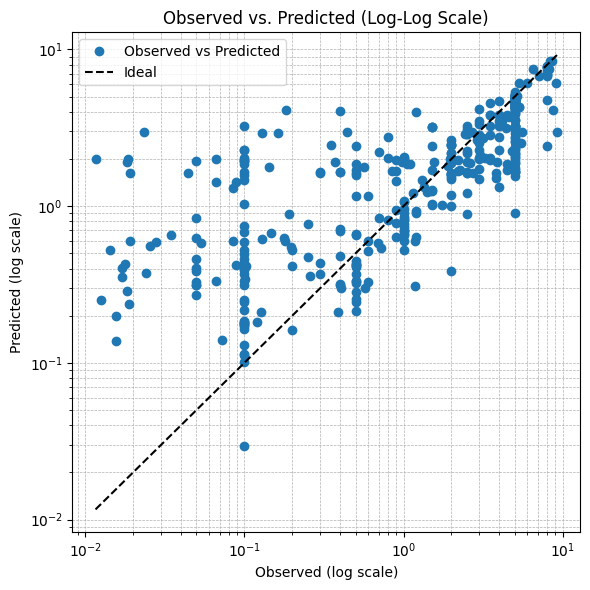

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#Model prediction
y_obs = y_re
all_preds = best_model.predict(X_re)

# # Transfer numpy
y_obs = np.ravel(y_obs)
all_preds = np.ravel(all_preds)

#  Plot
plt.figure(figsize=(6, 6))
plt.plot(y_obs, all_preds, 'o', label='Observed vs Predicted')

# linear regression line
log_y_obs = np.log10(y_obs )
log_y_pred = np.log10(all_preds)
m, b = np.polyfit(log_y_obs, log_y_pred, 1)

# y = x
plt.plot([y_obs.min(), y_obs.max()], [y_obs.min(), y_obs.max()], 'k--', label='Ideal')

#
plt.xscale("log")
plt.yscale("log")

# Label
plt.xlabel("Observed (log scale)")
plt.ylabel("Predicted (log scale)")
plt.title("Observed vs. Predicted (Log-Log Scale)")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [ ]:
PredKmax = pd.concat([pd.DataFrame(df_filtered["ID"].reset_index(drop=True)), pd.DataFrame(y_obs), pd.DataFrame(all_preds)], axis = 1)
PredKmax.columns = ["ID","Obs_KTRESn", "KTRESn"]
PredKmax.to_csv('KTRESN.csv', encoding = 'utf-8-sig',index=False)

##Cross validation

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import load_model, clone_model
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import tensorflow.keras as keras

dnn_base_model = keras.models.load_model("KTRESn_0519-1.keras")

kfold = KFold(n_splits=5, shuffle=True, random_state=1)
cvr2scores = []
cvrmsescores = []

for fold, (train_ix, test_ix) in enumerate(kfold.split(X_temp), 1):
    X_train_n, X_test_n = X_temp[train_ix], X_temp[test_ix]
    y_train_n, y_test_n = y_temp[train_ix], y_temp[test_ix]

    dnn_model = clone_model(dnn_base_model)
    dnn_model.set_weights(dnn_base_model.get_weights())
    dnn_model.compile(optimizer='Nadam', loss='mse')

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    dnn_model.fit(X_train_n, y_train_n, validation_data=(X_test_n, y_test_n), callbacks=[early_stop],
                  epochs=100, batch_size=32, verbose=0)

    # Prediction and Evaluation
    test_pred = dnn_model.predict(X_test_n).flatten()
    r2score = r2_score(y_test_n, test_pred)
    rmse = root_mean_squared_error(y_test_n, test_pred)

    print(f"[Fold {fold}] R²: {r2score:.3f}, RMSE: {rmse:.3f}")

    cvr2scores.append(r2score)
    cvrmsescores.append(rmse)

# Output performance
print("\n=== Cross-validation summary ===")
print("The 5-CV R² Score was: %.2f (+/- %.2f)" % (np.mean(cvr2scores), np.std(cvr2scores)))
print("The 5-CV RMSE Score was: %.2f (+/- %.2f)" % (np.mean(cvrmsescores), np.std(cvrmsescores)))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
[Fold 1] R²: 0.481, RMSE: 1.384
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step 
[Fold 2] R²: 0.634, RMSE: 1.279
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step 
[Fold 3] R²: 0.566, RMSE: 1.620
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step 
[Fold 4] R²: 0.385, RMSE: 1.644
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step 
[Fold 5] R²: 0.533, RMSE: 1.609

=== Cross-validation summary ===
The 5-CV R² Score was: 0.52 (+/- 0.08)
The 5-CV RMSE Score was: 1.51 (+/- 0.15)


#Make the prediction

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer


# importer Data
Data = pd.read_csv(os.path.join(root_dir + project_folder + "Data-prediction-1.csv"))
# Remove the row with missing data
Data=Data.dropna(subset=['Size','Zeta','Charge']) # you can use 'subset' (e.g., dropna(subset='HD')) to remove the missing value in specific column
df = pd.DataFrame(Data)

df_ori =df.iloc[0:-2]

q_high=df_ori["KTRESn"].quantile(0.975)
q_low=df_ori["KTRESn"].quantile(0.025)
df_filtered=df_ori[(df_ori["KTRESn"]<q_high)&(df_ori["KTRESn"]>q_low)]

df_merge = pd.concat([df_filtered, df.iloc[-2:]], axis=0)


df_X = df_merge[["ID","Type","TS",'MAT',"Size","Zeta","Shape","TSz","TM","CT",'Charge']]
df_y = df_merge[["KTRESn"]]

test_X = df_X

cat_encoder = OneHotEncoder(sparse_output=False)
cols_label_1hot = ["Type",'TS','Charge','Shape','TM','CT',"MAT"]
data_cat_1hot = pd.DataFrame(cat_encoder.fit_transform(test_X[cols_label_1hot]))
data_cat_1hot.columns = cat_encoder.get_feature_names_out(cols_label_1hot)

cols_num = ['Size','Zeta','TSz']

mscaler = MinMaxScaler()
Data_num_tr = pd.DataFrame(mscaler.fit_transform(test_X[cols_num]))
Data_num_tr.columns = list(test_X[cols_num].columns)

preData=pd.concat([Data_num_tr,data_cat_1hot], axis=1)

y_re = df_y
X_re = preData

In [ ]:
from tensorflow import keras
best_model= keras.models.load_model("KTRESn_0519-01.keras")

all_preds = best_model.predict(X_re.iloc[-2:])
all_preds

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'nadam', because it has 27 variables whereas the saved optimizer has 3 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


array([[1.4893978],
       [2.0486712]], dtype=float32)